<a href="https://colab.research.google.com/github/ads-predict-early-alzheimers/project/blob/main/project_part_1_transparency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alzheimer's prediction project_part_1_transparency

## What is Alzheimer's disease (AD)?

Alzheimer's disease (AD) is a neurodegenerative disease that usually starts slowly and progressively worsens.It is the cause of 60–70% of cases of dementia.The most common early symptom is difficulty in remembering recent events. As the disease advances, symptoms can include problems with language, disorientation (including easily getting lost), mood swings, loss of motivation, self-neglect, and behavioral issues. As a person's condition declines, they often withdraw from family and society.Gradually, bodily functions are lost, ultimately leading to death. Although the speed of progression can vary, the typical life expectancy following diagnosis is three to nine years.

## What is Dementia?

Dementia is a general term for loss of memory, language, problem-solving and other thinking abilities that are severe enough to interfere with daily life. Alzheimer's is the most common cause of dementia, a general term for memory loss and other cognitive abilities serious enough to interfere with daily life. Alzheimer's disease accounts for 60-80% of dementia cases.

### Our problem statement

Estimating the CDR (scale of Dementia) using relevant features in the MRI dataset.

The CDR is based on a scale of 0–3: no dementia (CDR = 0), questionable dementia (CDR = 0.5), MCI (CDR = 1), moderate cognitive impairment (CDR = 2), and severe cognitive impairment (CDR = 3).

In [1]:
import tensorflow.compat.v1 as tf
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.io import loadmat
import os
from pywt import wavedec
from functools import reduce
from scipy import signal
from scipy.stats import entropy
from scipy.fft import fft, ifft
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow import keras as K
import matplotlib.pyplot as plt
import scipy
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold,cross_validate
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt;
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from tensorflow.keras.layers import Conv1D,Conv2D,Add
from tensorflow.keras.layers import MaxPool1D, MaxPooling2D
import seaborn as sns

## Reading the Cross-sectional and Longitudinal MRI datasets.

We describe the attributes in the dataset with data_cross.info() and data_long.info()

In [2]:
import requests
import pandas as pd
import io

url = 'https://raw.githubusercontent.com/ads-predict-early-alzheimers/project/main/oasis_cross-sectional.csv'
response = requests.get(url)
assert response.status_code == 200, f"Failed to download the CSV file: {response.text}"

cross_content = response.content.decode('utf-8')
data_cross = pd.read_csv(io.StringIO(cross_content))

# Now, you have the CSV data in a pandas DataFrame called `data`


In [3]:
import requests
import pandas as pd

url = 'https://raw.githubusercontent.com/ads-predict-early-alzheimers/project/main/oasis_longitudinal.csv'
response = requests.get(url)
assert response.status_code == 200, f"Failed to download the CSV file: {response.text}"

long_content = response.content.decode('utf-8')
data_long = pd.read_csv(io.StringIO(long_content))

# Now, you have the CSV data in a pandas DataFrame called `data`


In [4]:
print(data_cross.info())
print(data_long.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   M/F     436 non-null    object 
 2   Hand    436 non-null    object 
 3   Age     436 non-null    int64  
 4   Educ    235 non-null    float64
 5   SES     216 non-null    float64
 6   MMSE    235 non-null    float64
 7   CDR     235 non-null    float64
 8   eTIV    436 non-null    int64  
 9   nWBV    436 non-null    float64
 10  ASF     436 non-null    float64
 11  Delay   20 non-null     float64
dtypes: float64(7), int64(2), object(3)
memory usage: 41.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 

## Checking for null values.

In [5]:
print(data_cross.isna().sum())
print("\n")
data_long.isna().sum()

ID         0
M/F        0
Hand       0
Age        0
Educ     201
SES      220
MMSE     201
CDR      201
eTIV       0
nWBV       0
ASF        0
Delay    416
dtype: int64




Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

Since we will be predicting on the variable "CDR", we drop all the rows with undefined or null values

In [6]:
data_cross.dropna(subset=['CDR'],inplace=True)

## Removing unnecessary columns in both datasets.
The unique columns would be of no use in estimating the dependent variable "CDR"

In [7]:
data_cross.drop(columns=['ID','Delay'],inplace=True)
data_long = data_long.rename(columns={'EDUC':'Educ'})
data_long.drop(columns=['Subject ID','MRI ID','Group','Visit','MR Delay'],inplace=True)

## Appending both the datasets.

In [8]:
data = pd.concat([data_cross,data_long])
data.head()

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
8,M,R,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
9,F,R,52,3.0,2.0,30.0,0.0,1321,0.827,1.329


In [9]:
data.describe()

,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
count,608.000000,608.000000,570.00000,606.000000,608.000000,608.000000,608.00000,608.000000
mean,75.208882,10.184211,2.47193,27.234323,0.288651,1477.062500,0.73713,1.203597
std,9.865026,6.058388,1.12805,3.687980,0.377697,170.653795,0.04267,0.135091
min,33.000000,1.000000,1.00000,4.000000,0.000000,1106.000000,0.64400,0.876000
25%,70.000000,4.000000,2.00000,26.000000,0.000000,1352.500000,0.70400,1.118000
50%,76.000000,12.000000,2.00000,29.000000,0.000000,1460.000000,0.73600,1.202000
75%,82.000000,16.000000,3.00000,30.000000,0.500000,1569.000000,0.76625,1.297500
max,98.000000,23.000000,5.00000,30.000000,2.000000,2004.000000,0.84700,1.587000


DATA EDA TO UNDERSTAND BASIC STASTICS AND DISTRIBUTIONS OF THE DATASET. 

This is the first step in the data analysis process to get some knowledge about the dataset before we start performing data preprocessing. We can find certain patterns and distributions of the dataset which can further help us in training the model on this dataset in future. 


a. Describe the data used by this ADS. How was this data collected or selected?

b. For each input feature, describe its datatype, give information on missing values and on the value distribution. Show pairwise correlations between features if appropriate. Run any other reasonable profiling of the input that you find interesting and appropriate.

c. What is the output of the system (e.g., is it a class label, a score, a probability, or some other type of output), and how do we interpret it? 

Lets make a function which gives us a basic description of the dataset. This function would provide us with the following info about each numeric feature in data.

1. Mean, Median, Min and Max value. Also we will show the box-plot for the feature. Boxplots shows the distribution of the feature
2. Datatypes.
3. Number of missing values.

Also we will be showing the pairwise correlations between features of the data. 


In [10]:
import matplotlib.pyplot as plt

def mydescriber(data):
  #fig, ax = plt.subplots(2,4,figsize=(30,12))
  column_names = ['Age','Educ','SES','MMSE','CDR','eTIV','nWBV','ASF']
  print(column_names)
  for n, f in enumerate(column_names):
    print("Feature Name : ",f)
    if(pd.api.types.is_numeric_dtype(data[f]) == True):
      print("Mean : ",data[f].mean())
      print("Median : ",data[f].median())
      print("Min Value : ",data[f].min())
      print("Max Value : ",data[f].max())
      #plt.boxplot(data[f],whis=[5, 95])
      #ax[int(np.floor(n/4)),n%4].set_title(f)

In [11]:
import sklearn.model_selection
import sklearn.metrics
import sklearn.datasets
import sklearn.ensemble
import sklearn.preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import warnings
import lime
import lime.lime_tabular
from lime import submodular_pick
import xgboost
from xgboost import plot_importance
import json
from collections import OrderedDict

import pandas as pd

In [12]:
feature_names = ['M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']

In [13]:
# Mark labels and encode them using sklearn
labels = data['CDR']
le= sklearn.preprocessing.LabelEncoder()
le.fit(labels)
labels = le.transform(labels)
class_names = le.classes_
data = data.drop('CDR',axis=1)
le_label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Class names: ", class_names)
print("Label mapping: ", le_label_mapping)

Class names:  [0.  0.5 1.  2. ]
Label mapping:  {0.0: 0, 0.5: 1, 1.0: 2, 2.0: 3}


In [14]:
# Check if there are categorical varibles that we need to make dummies for
print(data.dtypes)
# Get a list of which variables are categorical
# we record the index of these columns since it is a required input format later in LIME
categorical_features  = [i for i in range(len(data.dtypes)) if data.dtypes[i]=='object']
print("Indices of categorical features: ", categorical_features)

M/F      object
Hand     object
Age       int64
Educ    float64
SES     float64
MMSE    float64
eTIV      int64
nWBV    float64
ASF     float64
dtype: object
Indices of categorical features:  [0, 1]


In [15]:
categorical_names = {}
for feature in categorical_features:
    print("Feature: ", feature)
    # Use label encoder to map categories to numbers
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(data.iloc[:, feature])
    # Replace the categories with corresponding numbers in the original data
    data.iloc[:, feature] = le.transform(data.iloc[:, feature])
    # Store and print the mappings for reference later
    categorical_names[feature] = le.classes_
    print(categorical_names[feature])
    print("==================================================")

Feature:  0
['F' 'M']
Feature:  1
['R']


<ipython-input-15-b2a445afd202>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, feature] = le.transform(data.iloc[:, feature])
<ipython-input-15-b2a445afd202>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, feature] = le.transform(data.iloc[:, feature])


In [16]:
# We can (and will) use this encoder function to transform the categorical columns into dummies-- 
# but we can't do that to the original dataset if we want to use LIME

encoder = ColumnTransformer(transformers=[('get_dummies', 
                                           OneHotEncoder(), 
                                           categorical_features)], remainder='passthrough')
encoder = encoder.fit(data)

## Imputing columns using SimpleImputer.
We fill in the missing values in the "SES" columns with the most occuring data element.
Similarly, we fill the missing values in the "MMSE" column with the median of that column.

In [17]:
from sklearn.impute  import SimpleImputer
imputer = SimpleImputer ( missing_values = np.nan,strategy='most_frequent')

imputer.fit(data[['SES']])
data[['SES']] = imputer.fit_transform(data[['SES']])

# We perform it with the median
imputer = SimpleImputer ( missing_values = np.nan,strategy='median')

imputer.fit(data[['MMSE']])
data[['MMSE']] = imputer.fit_transform(data[['MMSE']])

In [18]:
data

,M/F,Hand,Age,Educ,SES,MMSE,eTIV,nWBV,ASF
0,0,0,74,2.0,3.0,29.0,1344,0.743,1.306
1,0,0,55,4.0,1.0,29.0,1147,0.810,1.531
2,0,0,73,4.0,3.0,27.0,1454,0.708,1.207
8,1,0,74,5.0,2.0,30.0,1636,0.689,1.073
9,0,0,52,3.0,2.0,30.0,1321,0.827,1.329
...,...,...,...,...,...,...,...,...,...
368,1,0,82,16.0,1.0,28.0,1693,0.694,1.037
369,1,0,86,16.0,1.0,26.0,1688,0.675,1.040
370,0,0,61,13.0,2.0,30.0,1319,0.801,1.331
371,0,0,63,13.0,2.0,30.0,1327,0.796,1.323


In [19]:
for i, col_type in enumerate(data.dtypes):
    if col_type == "object":
        print("\nVariable {} takes the values: {}".format(
            data.columns[i],
            data[data.columns[i]].unique()))

## Encoding the Target variable using LabelEncoder.

In [20]:
#from sklearn import preprocessing
#le = preprocessing.LabelEncoder()
#data['CDR'] = le.fit_transform(data['CDR'].values)

Converting categorical variables to numeric using OneHot encoding.

In [21]:
#data = pd.get_dummies(data)

## Plotting the distribution of classes on a barplot.

In [22]:
#plt.bar(data['CDR'].unique(),data['CDR'].value_counts())

Neglecting the last class due to negligible size in the combined dataset.

In [23]:
#data = data.drop(data[data['CDR']==3].index)
#data.info()

In [24]:
y = labels
x = data

## Normalizing the data.
We observe that different columns have different ranges of values. We use Z-score normalization in this case.

## Dividing dataset into train and test sets.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42,test_size=0.3)

## Defining Models.



```
# This is formatted as code
```

### 1. We will try hyperparameter tuning using cross-validation for XGBClassifier.

In [26]:
from xgboost import XGBClassifier
FOLDS = 5

parametros_xgb = {
    "learning_rate": [0.01, 0.025, 0.005,0.5, 0.075, 0.1, 0.15, 0.2,0.3,0.8,0.9],
    "max_depth":[3,5,8,10,15,20,25,30,40,50],
    "n_estimators":range(1,1000)
    }

model_xgb= XGBClassifier(eval_metric='mlogloss')


xgb_random = RandomizedSearchCV(estimator = model_xgb, param_distributions = parametros_xgb, n_iter = 100, cv = FOLDS, 
                               verbose=0, random_state=42,n_jobs = -1, scoring='accuracy')
xgb_random.fit(X_train, y_train)

xgb_random.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


{'n_estimators': 798, 'max_depth': 10, 'learning_rate': 0.9}

In [27]:
model_xgb = xgb_random.best_estimator_
model_xgb.fit(X_train,y_train)
model_xgb.score(X_test,y_test)

0.7814207650273224

### 2. Trying hyperparameter tuning of GradientBoostingClassifier.

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
FOLDS =10

parametros_gb = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.005,0.5, 0.075, 0.1, 0.15, 0.2,0.3,0.8,0.9],
    "min_samples_split": [0.01, 0.025, 0.005,0.4,0.5, 0.075, 0.1, 0.15, 0.2,0.3,0.8,0.9],
    "min_samples_leaf": [1,2,3,5,8,10,15,20,40,50,55,60,65,70,80,85,90,100],
    "max_depth":[3,5,8,10,15,20,25,30,40,50],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "squared_error"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":range(1,100)
    }

model_gb= GradientBoostingClassifier()


gb_random = RandomizedSearchCV(estimator = model_gb, param_distributions = parametros_gb, n_iter = 100, cv = FOLDS, 
                               verbose=0, random_state=42,n_jobs = -1, scoring='accuracy')
gb_random.fit(X_train, y_train)

gb_random.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


{'subsample': 0.618,
 'n_estimators': 84,
 'min_samples_split': 0.1,
 'min_samples_leaf': 10,
 'max_features': 'sqrt',
 'max_depth': 20,
 'loss': 'deviance',
 'learning_rate': 0.3,
 'criterion': 'squared_error'}

In [29]:
model_gb = gb_random.best_estimator_
print(model_gb.score(X_test,y_test))

0.7540983606557377


GradientBoosting model performs better than XGboost, Hence we try 10-fold cross validation on GradientBoostingClassifier model to improve accuracy.

In [30]:
cross_val_score(model_gb, x, y, cv=10, scoring='accuracy').mean()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklear

0.7909836065573771

### Making predictions using the best estimator and plotting the confusion matrix along with classification report.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


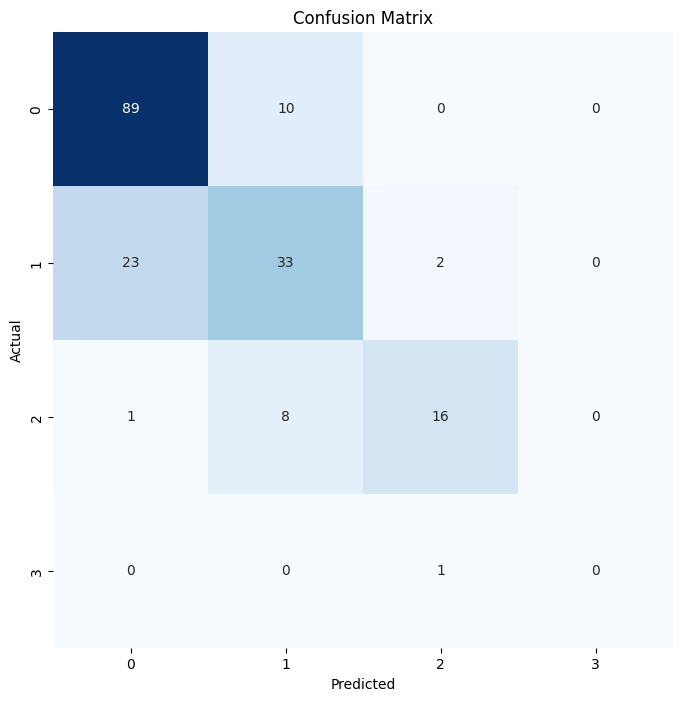

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.79      0.90      0.84        99
           1       0.65      0.57      0.61        58
           2       0.84      0.64      0.73        25
           3       0.00      0.00      0.00         1

    accuracy                           0.75       183
   macro avg       0.57      0.53      0.54       183
weighted avg       0.75      0.75      0.75       183



In [31]:
y_pred = model_gb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)


In [32]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=feature_names,
                                                   class_names=class_names,
                                                   categorical_features=categorical_features, 
                                                   categorical_names=categorical_names)

In [36]:
predict_fn = lambda x: model_xgb.predict_proba(encoder.transform(x)).astype(float)

In [40]:
i = 0
print('Predicted class: ', y_pred[i])
print('Actual class: ', y_test[i])
# Get explanation
exp = explainer.explain_instance((X_test.values[i]), predict_fn, num_features=9)

Predicted class:  1
Actual class:  0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


ValueError: ignored

In [34]:
exp.as_list()

NameError: ignored

In [ ]:
# Visualize the explanation 
%matplotlib inline

# fig = exp.as_pyplot_figure() 
#   can serve the same purpose but with the version installed, 
#   it's hard to control the details of the plot, such as the figure size 
fig = plt.figure(figsize=(4, 4))
vals = [x[1] for x in exp.as_list(label=1)]
names = [x[0] for x in exp.as_list(label=1)]
vals.reverse()
names.reverse()
colors = ['green' if x > 0 else 'red' for x in vals]
pos = np.arange(len(exp.as_list(label=1))) + .5
plt.barh(pos, vals, align='center', color=colors)
plt.yticks(pos, names)
if exp.mode == "classification":
    title = 'Local explanation for class %s' % exp.class_names[0]
else:
    title = 'Local explanation'
plt.title(title)